In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import pandas as pd

In [2]:
r_layer = np.array(
    [
        0.0431818181818182,
        17.7692400386911,
        0.09
    ]
)

c_layer = np.array(
    [
        7.885,
        7.10769601547645,
        0.0
    ]
) * 1000.0

# c_layer = np.array([
#     10375.0,
#     0.0,
#     10375.0,
#     0.0
# ])

# r_layer = np.array([
#     0.0568,
#     0.09,
#     0.0568,
#     0.120289612356129
# ])

In [3]:
# 伝達関数の計算
def calc_transfer_function(C_i_k_p: np.ndarray, R_i_k_p: np.ndarray, laps: float) -> (float, float):

    """

    Args:
        C_i_k_p: 層の熱容量[J/m2K]
        R_i_k_p: 層の熱抵抗[m2K/W]
        laps: ラプラス変数[1/s]

    Returns:
        貫流伝達関数[K]
        吸熱伝達関数[K]
    """

    # 四端子行列の初期化
    matFt = np.identity(2, dtype=float)

    for lngK, (R_k, C_k) in enumerate(zip(R_i_k_p, C_i_k_p)):

        # ---- 四端子基本行列 matFi ----
        if abs(C_k) < 0.001:
            # 定常部位（空気層等）の場合
            matFi = np.array([
                [1.0, R_k],
                [0.0, 1.0]
            ])
        else:
            # 非定常部位の場合
            dblTemp = np.sqrt(R_k * C_k * laps)
            dblCosh = np.cosh(dblTemp)
            dblSinh = np.sinh(dblTemp)

            matFi = np.array([
                [dblCosh, R_k / dblTemp * dblSinh],
                [dblTemp / R_k * dblSinh, dblCosh]
            ])

        # print('[Fi(', lngK, ')]')
        # print(matFi)

        # ---- 四端子行列 matFt ----
        matFt = np.dot(matFt, matFi)

    # print('martFt')
    # print(matFt)

    # 吸熱、貫流の各伝達関数ベクトルの作成
    GA = matFt[0, 1] / matFt[1, 1]
    GT = 1.0 / matFt[1][1]

    return (GA, GT)

In [4]:
a0 = 1.0
b0 = np.sum(r_layer)
alpha_m = np.logspace(np.log10(1.0 / (86400.0 * 365.0)), np.log10(1.0 / 900.0), 10)
alpha_m_temp = alpha_m
nroot = len(alpha_m)

In [5]:
# 実際に応答係数計算に使用する固定根を選定する
GA = np.zeros_like(alpha_m_temp, dtype=float)
GT = np.zeros_like(alpha_m_temp, dtype=float)

In [6]:
# 固定根をラプラスパラメータとして伝達関数を計算
for i, lap in enumerate(alpha_m_temp):
    (GA[i], GT[i]) = calc_transfer_function(C_i_k_p=c_layer, R_i_k_p=r_layer, laps=lap)

print('GA=', GA)
print('GT=', GT)

GA= [17.79900507 17.57583583 16.89855821 15.04756858 11.16123202  6.16147653
  2.59778117  0.9566404   0.33751295  0.12111972]
GT= [9.93544723e-01 9.79616413e-01 9.37363499e-01 8.22039254e-01
 5.81013360e-01 2.76446087e-01 7.59080253e-02 9.38920057e-03
 3.00545408e-04 8.90621037e-07]


In [7]:
GT2 = np.zeros(nroot + 2, dtype=float)
# 配列0に定常の伝達関数を入力
GT2[0] = 1.0
# 配列の最後にs=∞の伝達関数を入力
GT2[nroot - 1] = 0.0
# それ以外に計算した伝達関数を代入
for i in range(nroot):
    GT2[i + 1] = GT[i]

# 採用する固定根の場合1
is_adopts = np.zeros(nroot, dtype=int)
i = 0
while i <= nroot + 1:
    for j in range(i + 1, nroot + 1):
        # 伝達関数が3%以上変化した根だけ採用する
        if math.fabs(GT2[j] - GT2[i]) > 1.0 * 0.03:
            is_adopts[j - 1] = 1
            i = j - 1
            break
    i += 1

# 採用する根を数える
adopt_nroot = sum(is_adopts)

# 不採用の固定根を削除
for i, adopts in enumerate(reversed(is_adopts)):
    if adopts == 0:
        alpha_m_temp = np.delete(alpha_m_temp, nroot - i - 1)

In [8]:
# ラプラス変数の設定
def get_laps(alp: np.ndarray) -> np.ndarray:
    """
    :param alp: 固定根
    :return: ラプラス変数の配列
    """
    n = len(alp) * 2  # 与えるラプラス変数の個数
    laps = [None] * n  # ラプラス変数の配列

    for i in range(1, n + 1):
        if i % 2 == 0:
            # 偶数番目はαをそのまま入力
            laps[i - 1] = alp[int((i - 1) / 2)]
        elif i == 1:
            # 最初はα1/√(α2/α1）とする
            laps[i - 1] = alp[0] / math.sqrt(alp[1] / alp[0])
        else:
            # それ以外は等比数列で補間
            lngL = math.ceil((i - 1) / 2)
            laps[i - 1] = alp[lngL] / math.sqrt(alp[lngL] / alp[lngL - 1])

    return np.array(laps)

In [9]:
# ラプラス変数の設定
laps = get_laps(alpha_m_temp)

In [10]:
# 貫流単位応答の下限値と上限値を保証する制約関数
def phi_t(x, t):
    phi = np.zeros(len(t))
    for i, ti in enumerate(t):
        phi[i] = a0 + np.sum(x * np.exp(-alpha_m_temp * ti * 900))

    return phi

In [11]:
# 吸熱単位応答の下限値と上限値を保証する制約関数
def phi_a(x, t):
    phi = np.zeros(len(t))
    for i, ti in enumerate(t):
        phi[i] = b0 + np.sum(x * np.exp(-alpha_m_temp * ti * 900))
    
    return phi

In [12]:
# x1 + x2 + x3 + x4 ・・・ + Y =0 制約
# 貫流応答用
def sum_constraint_t(x):
    return a0 * 0.05 - abs(np.sum(x) + a0)

# 吸熱応答用
def sum_constraint_a(x):
    return b0 * 0.05 - abs(np.sum(x) + b0)

In [13]:
# tの範囲を離散的な点に分割
t_values = np.linspace(0, 2000, num=2000)


In [14]:
# tに対する単位応答の微分が0以上であることを保証する制約関数
def diff_phi(x, t):
    diff = np.zeros_like(t)
    for i, ti in enumerate(t):
        diff[i] = np.sum(-alpha_m_temp * x * np.exp(-alpha_m_temp * ti * 900))
    
    return diff


In [15]:
# 制約の追加
cons_t = [
        {
            'type': 'ineq',
            'fun': sum_constraint_t
        },
        {
            'type': 'ineq',
            'fun': lambda x, t=t_values: phi_t(x, t) - 0  # g(x, s) >= 0
        },
        {
            'type': 'ineq',
            'fun': lambda x, t=t_values: a0 - phi_t(x, t)  # g(x, s) <= 1
        },
        {
            'type': 'ineq',
            'fun': lambda x, t=t_values: diff_phi(x, t) - 0  # dg(x, s) >= 0
        }
    ]

cons_a = [
        {
            'type': 'ineq',
            'fun': sum_constraint_a
        },
        {
            'type': 'ineq',
            'fun': lambda x, t=t_values: phi_a(x, t) - 0  # g(x, s) >= 0
        },
        {
            'type': 'ineq',
            'fun': lambda x, t=t_values: b0 - phi_a(x, t)  # g(x, s) <= b0
        },
        {
            'type': 'ineq',
            'fun': lambda x, t=t_values: diff_phi(x, t) - 0  # dg(x, s) >= 0
        }
    ]

In [16]:
# 伝達関数の係数を求めるための左辺行列を作成
mat_f = np.zeros((len(laps), len(alpha_m_temp)))
for i, lap in enumerate(laps):
    for j, root in enumerate(alpha_m_temp):
        mat_f[i, j] = lap / (lap + root)

In [17]:
# 定数行列の作成
mat_gt = np.zeros(len(laps))
mat_ga = np.zeros(len(laps))

for i, lap in enumerate(laps):

    # 伝達関数の計算
    (ga_value, gt_value) = calc_transfer_function(C_i_k_p=c_layer, R_i_k_p=r_layer, laps=lap)

    mat_gt[i] = gt_value - a0
    mat_ga[i] = ga_value - b0

print(mat_gt)
print(mat_ga)

[-0.03592818 -0.0626365  -0.10718931 -0.17796075 -0.28206179 -0.41898664
 -0.57452324 -0.72355391 -0.84325058 -0.92409197 -0.96972995 -0.9906108 ]
[ -0.57570363  -1.00386364  -1.7184913   -2.85485328  -4.52969528
  -6.74118984  -9.27329438 -11.74094533 -13.79799358 -15.30464069
 -16.31101257 -16.94578146]


In [18]:
def calc_error_t(x):

    error = np.sum((mat_gt - np.sum(mat_f * x, axis=1)) ** 2, axis=0)
    # print(error)
    return error

def calc_error_a(x):
    
    error = np.sum((mat_ga - np.sum(mat_f * x, axis=1)) ** 2, axis=0)
    # print(error)
    return error

In [19]:
# 最適化の実行

# 初期値
xt0 = np.full(len(alpha_m_temp), -a0 / len(alpha_m_temp), float)

result_t = minimize(calc_error_t, xt0, method='COBYLA', constraints=cons_t, tol=1.0e-8)

print(result_t)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 4.0555381619245286e-05
       x: [-7.794e-03  3.694e-02 -5.342e-01 -8.675e-01  3.990e-01
           -2.650e-02]
    nfev: 1000
   maxcv: 2.220446049250313e-16


In [20]:
# 初期値
xa0 = np.full(len(alpha_m_temp), -b0 / len(alpha_m_temp), float)

result_a = minimize(calc_error_a, xa0, method='COBYLA', constraints=cons_a, tol=1.0e-5)

print(result_a)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.13530914551770434
       x: [ 1.811e-01 -5.118e-01 -8.633e+00 -9.311e+00 -7.171e-01
            1.402e+00]
    nfev: 1000
   maxcv: 2.710505431213761e-20


<Axes: xlabel='x', ylabel='phi_t'>

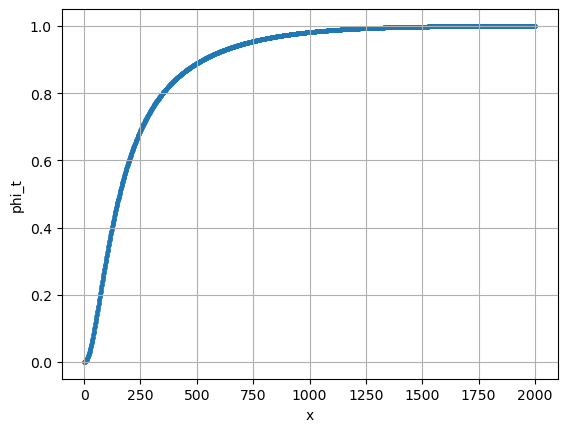

In [21]:
phi_t = phi_t(x=result_t.x, t=t_values)

df_t = pd.DataFrame(columns=['x', 'phi_t'])
df_t['x'] = t_values
df_t['phi_t'] = phi_t


df_t.plot.scatter(x='x', y='phi_t', s=5, grid=True)

<Axes: xlabel='x', ylabel='phi_a'>

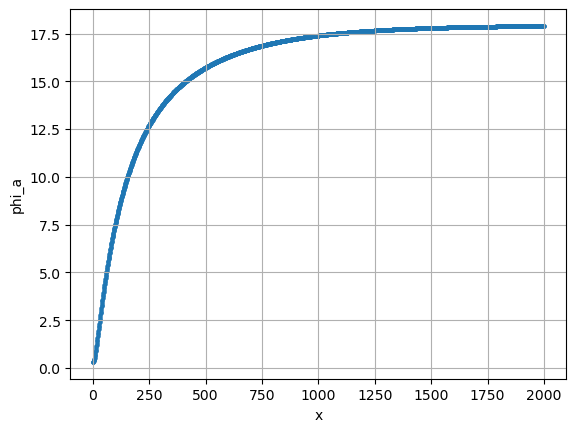

In [22]:
phi_a = phi_a(x=result_a.x, t=t_values)

df_a = pd.DataFrame(columns=['x', 'phi_a'])
df_a['x'] = t_values
df_a['phi_a'] = phi_a


df_a.plot.scatter(x='x', y='phi_a', s=5, grid=True)